In [91]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import os
from cellpose import io
from liams_funcs import *
from features import *

import pandas as pd

In [92]:
control_dir = '../control_images/'
penetramax_dir = '../penetramax_images/'

control_fnames = [control_dir + fname for fname in os.listdir(control_dir)]
penetramax_fnames = [penetramax_dir + fname for fname in os.listdir(penetramax_dir)]

In [93]:
fname1 = '../control_images/001_z26.png'
fname2 = '../penetramax_images/011_z57.png'

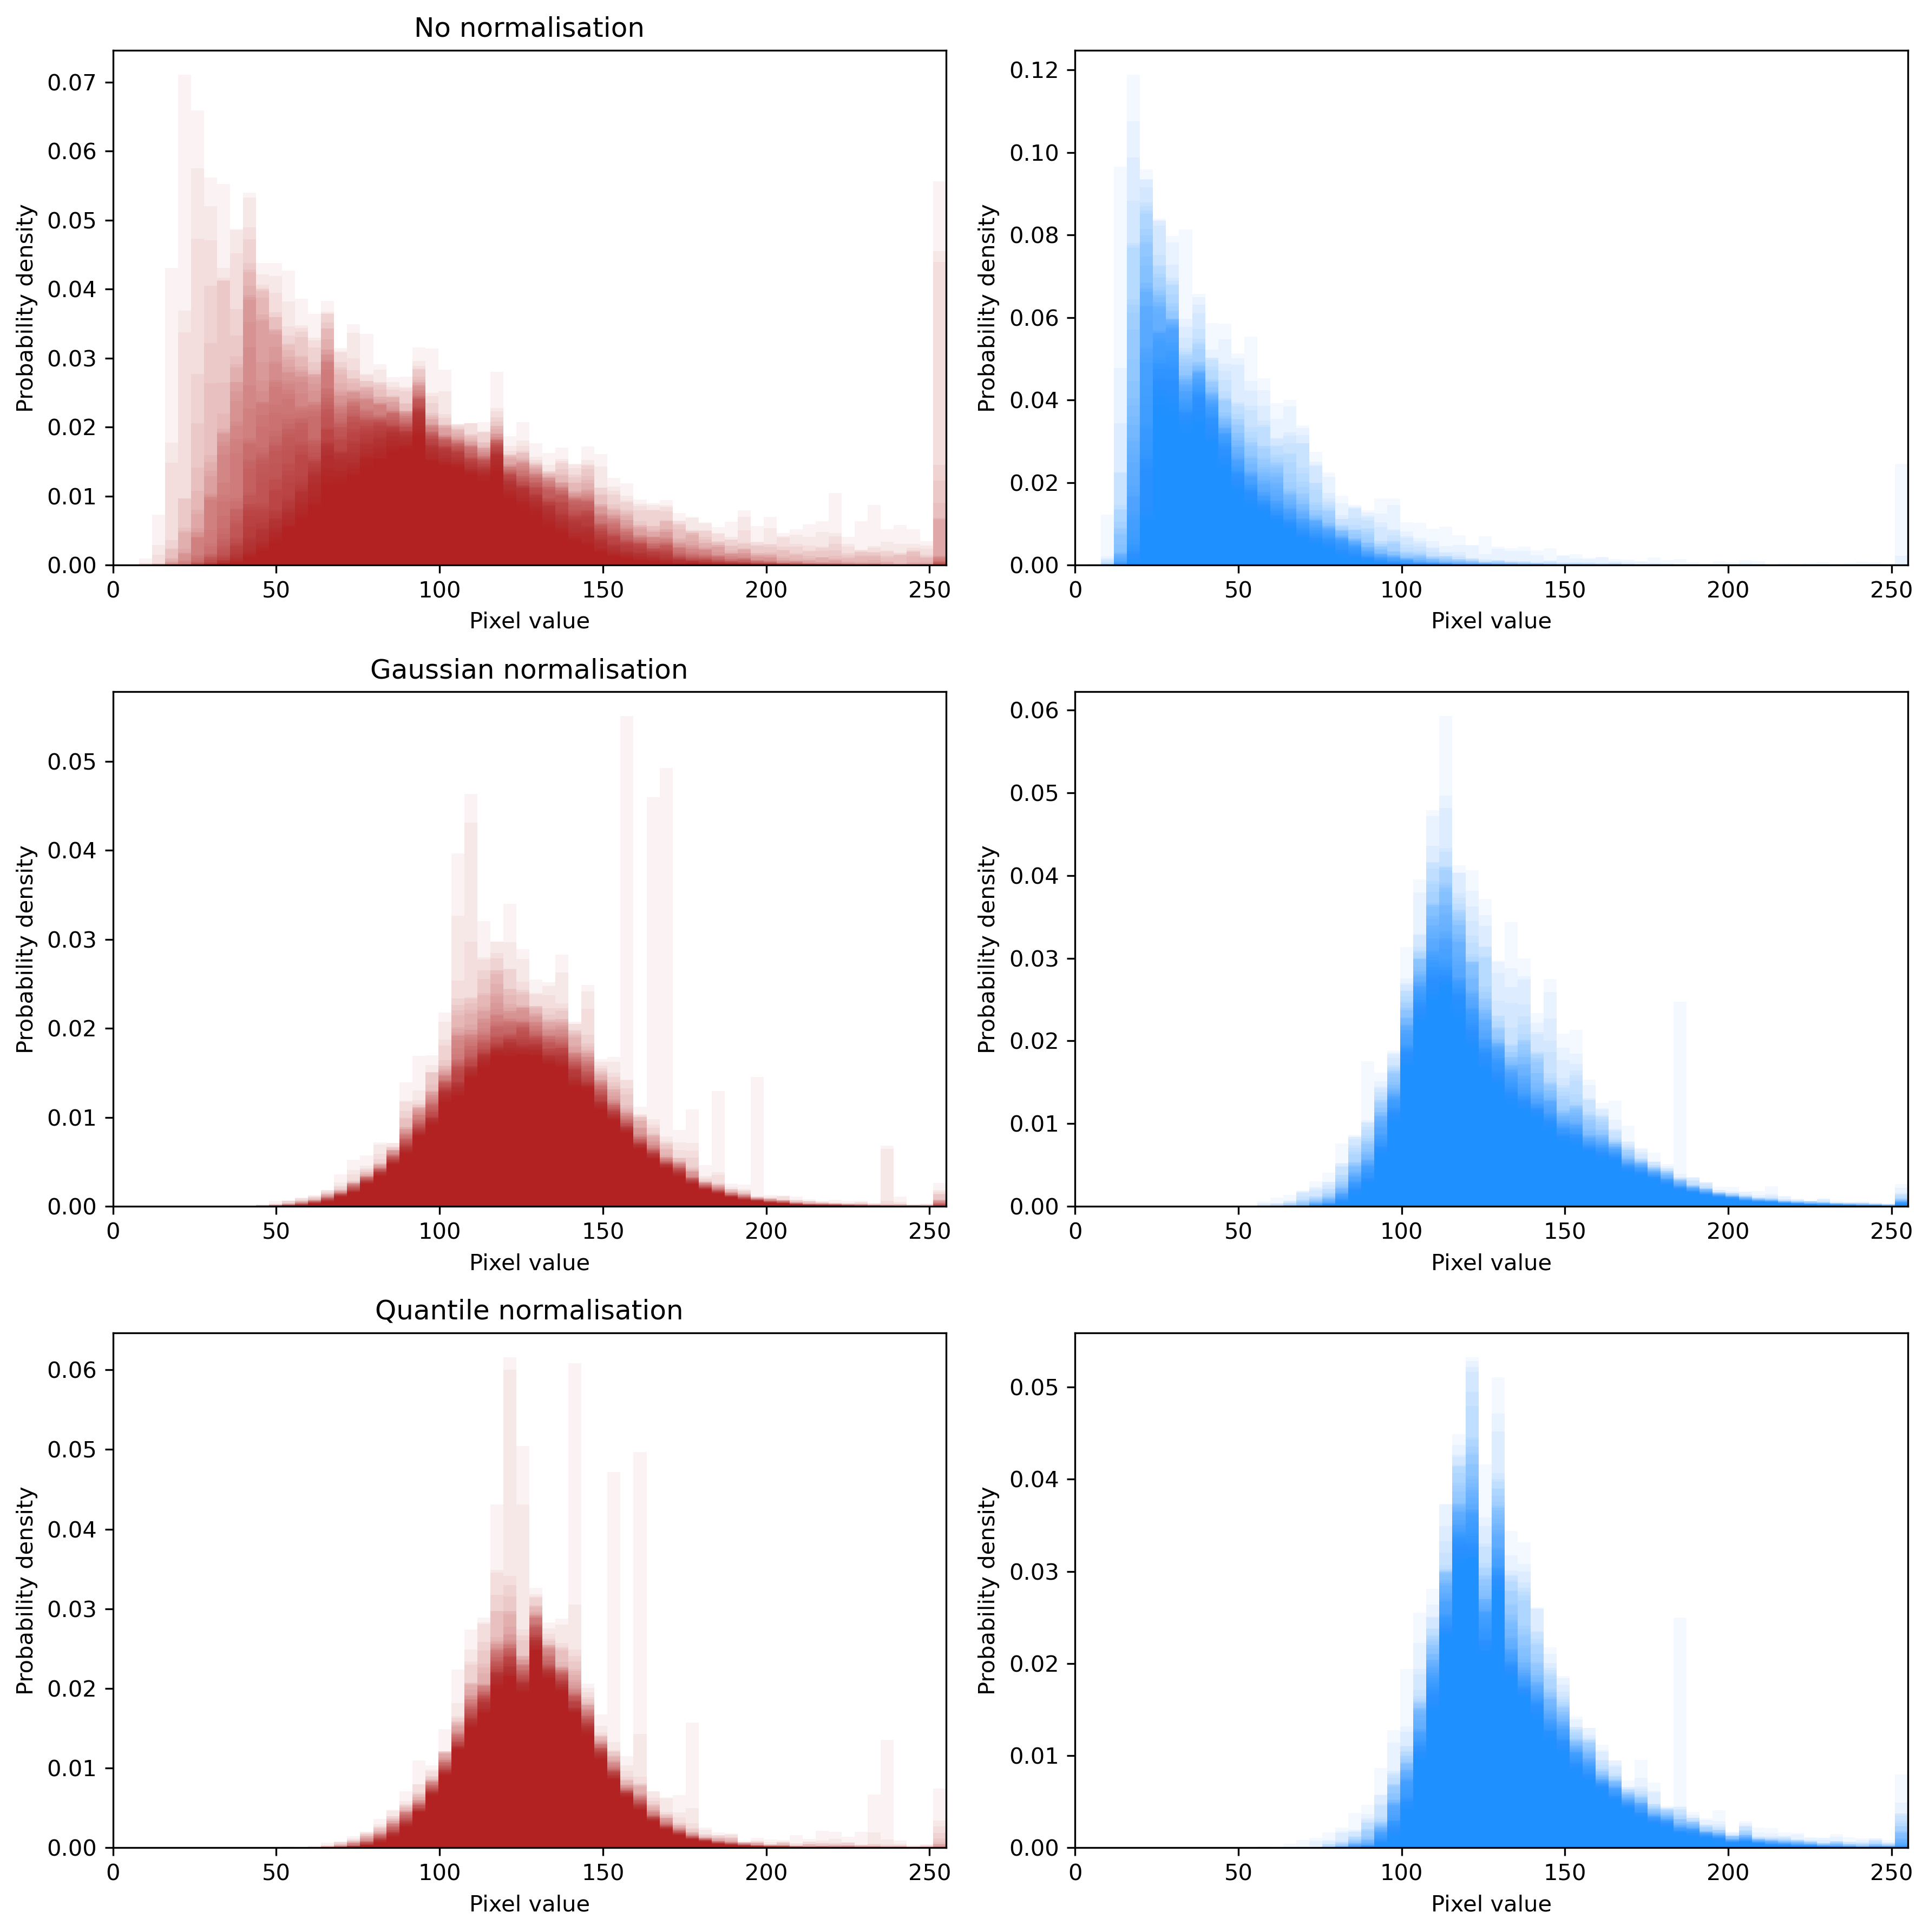

In [94]:
data = np.load('../segments/control/001_z26.png.npy')
image = io.imread('../control_images/001_z26.png')

reds, blues = image[:,:,0], image[:,:,2]
combined_cells, combined_nuclei = data[:,:,0], data[:,:,1]

vals = get_mask_levels(combined_nuclei)
fig, axes = plt.subplots(3, 2, figsize=(12, 12), dpi=300)

for val in vals:
    mask = (combined_nuclei == val)
    red = reds[mask]
    blue = blues[mask]

    counts_red, edges = np.histogram(red, bins=64, range=(0,255), density=True)
    counts_blue, _ = np.histogram(blue, bins=64, range=(0,255), density=True)

    axes[0,0].stairs(counts_red, edges, fill=True, alpha=0.05, color='firebrick')
    axes[0,1].stairs(counts_blue, edges, fill=True, alpha=0.05, color='dodgerblue')

    counts_red, edges = np.histogram(ZtoRGB(gaussian_normalisation(red)), bins=64, range=(0, 255), density=True)
    counts_blue, _= np.histogram(ZtoRGB(gaussian_normalisation(blue)), bins=64, range=(0, 255), density=True)

    axes[1,0].stairs(counts_red, edges, fill=True, alpha=0.05, color='firebrick')
    axes[1,1].stairs(counts_blue, edges, fill=True, alpha=0.05, color='dodgerblue')

    counts_red, edges = np.histogram(ZtoRGB(quantile_normalisation(red)), bins=64, range=(0, 255), density=True)
    counts_blue, _ = np.histogram(ZtoRGB(quantile_normalisation(blue)), bins=64, range=(0, 255), density=True)

    axes[2,0].stairs(counts_red, edges, fill=True, alpha=0.05, color='firebrick')
    axes[2,1].stairs(counts_blue, edges, fill=True, alpha=0.05, color='dodgerblue')

for ax in axes.flatten():
    ax.set_ylim(0)
    ax.set_ylabel('Probability density')
    ax.set_xlabel('Pixel value')
    ax.set_xlim(0, 255)
    
axes[0,0].set_title('No normalisation'); axes[1,0].set_title('Gaussian normalisation'); axes[2,0].set_title('Quantile normalisation')

plt.tight_layout()
plt.savefig('../figures/spectrum_normalisations_control.png', dpi=300, bbox_inches='tight')
plt.show()

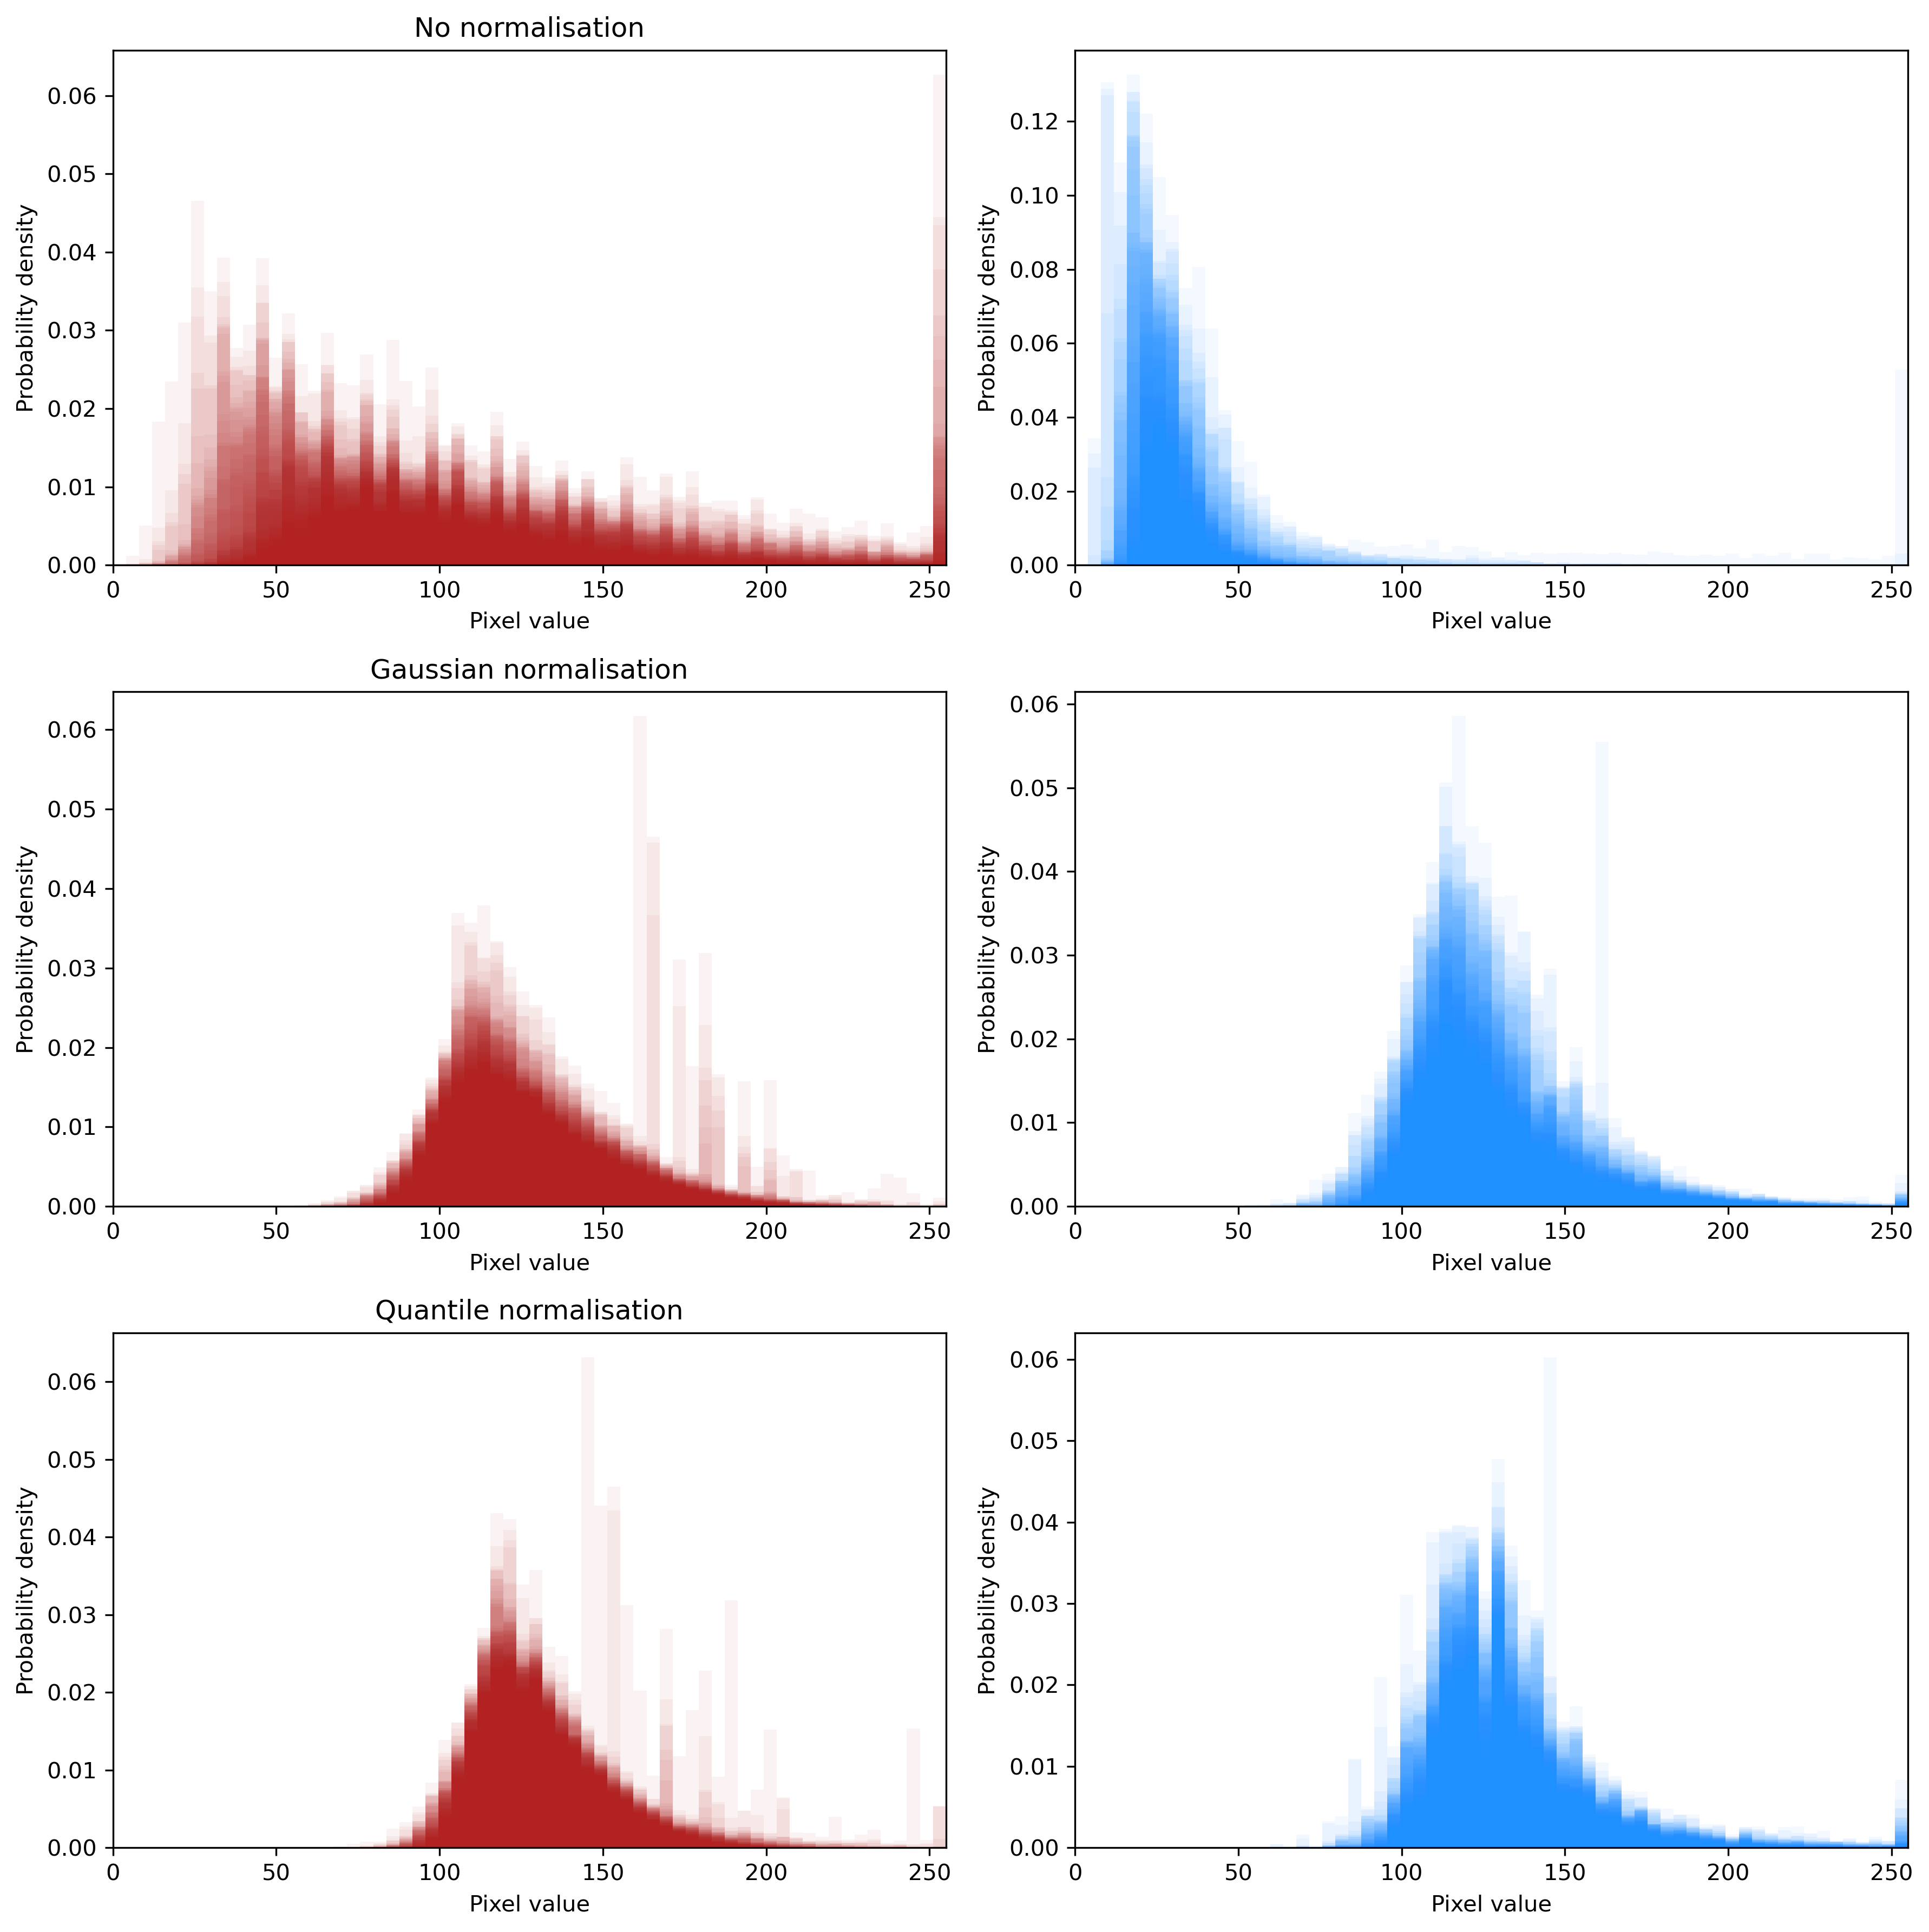

In [95]:
data = np.load('../segments/penetramax/011_z57.png.npy')
image = io.imread('../penetramax_images/011_z57.png')

reds, blues = image[:,:,0], image[:,:,2]
combined_cells, combined_nuclei = data[:,:,0], data[:,:,1]

vals = get_mask_levels(combined_nuclei)
fig, axes = plt.subplots(3, 2, figsize=(12, 12), dpi=300)

for val in vals:
    mask = (combined_nuclei == val)
    red = reds[mask]
    blue = blues[mask]

    counts_red, edges = np.histogram(red, bins=64, range=(0,255), density=True)
    counts_blue, _ = np.histogram(blue, bins=64, range=(0,255), density=True)

    axes[0,0].stairs(counts_red, edges, fill=True, alpha=0.05, color='firebrick')
    axes[0,1].stairs(counts_blue, edges, fill=True, alpha=0.05, color='dodgerblue')

    counts_red, edges = np.histogram(ZtoRGB(gaussian_normalisation(red)), bins=64, range=(0, 255), density=True)
    counts_blue, _= np.histogram(ZtoRGB(gaussian_normalisation(blue)), bins=64, range=(0, 255), density=True)

    axes[1,0].stairs(counts_red, edges, fill=True, alpha=0.05, color='firebrick')
    axes[1,1].stairs(counts_blue, edges, fill=True, alpha=0.05, color='dodgerblue')

    counts_red, edges = np.histogram(ZtoRGB(quantile_normalisation(red)), bins=64, range=(0, 255), density=True)
    counts_blue, _ = np.histogram(ZtoRGB(quantile_normalisation(blue)), bins=64, range=(0, 255), density=True)

    axes[2,0].stairs(counts_red, edges, fill=True, alpha=0.05, color='firebrick')
    axes[2,1].stairs(counts_blue, edges, fill=True, alpha=0.05, color='dodgerblue')

for ax in axes.flatten():
    ax.set_ylim(0)
    ax.set_ylabel('Probability density')
    ax.set_xlabel('Pixel value')
    ax.set_xlim(0, 255)
    
axes[0,0].set_title('No normalisation'); axes[1,0].set_title('Gaussian normalisation'); axes[2,0].set_title('Quantile normalisation')

plt.tight_layout()
plt.savefig('../figures/spectrum_normalisations_drug.png', dpi=300, bbox_inches='tight')
plt.show()

In [96]:
from sklearn.preprocessing import StandardScaler
class Dataset:
    def __init__(self, control_paths, penetramax_paths, scaler=StandardScaler):
        from pandas import concat
        from tqdm import tqdm

        self.control_paths = control_paths
        self.penetramax_paths = penetramax_paths

        # Create list of Masks objects
        print("Instantiating masks...")
        self.masks = []
        loop = tqdm(zip(self.control_paths + self.penetramax_paths, len(self.control_paths) * ['control'] + len(self.penetramax_paths) * ['penetramax']))
        for fname, type in loop:
            self.masks.append(Masks(fname.split('/')[-1], type=type))

        # Combined feature dataframes from each object
        print("Retrieving features...")
        dfs = []
        for mask in tqdm(self.masks):
            dfs.append(mask.getDataFrame())
        self.df = concat(dfs)
        self.feature_names = self.masks[0].segments[0].retrieveFeatureNames()
        self.feature_df = self.df[self.feature_names]

        # X-matrices
        self.X = self.feature_df.to_numpy()
        self.scaler = scaler().fit(self.X)
        self.X_scaled = self.scaler.transform(self.X)
        self.y = self.df['label'].to_numpy()

        self.X_reduced = None
        self.X_control_reduced = None
        self.X_penetramax_reduced = None

    from sklearn.decomposition import PCA
    def performDimReduction(self, n_components:int=2, Algo=PCA):
        self.n_components = n_components
        algo = Algo(n_components=self.n_components)

        is_control = (self.y==0)
        X_control = self.X_scaled[is_control,:]
        X_penetramax = self.X_scaled[~is_control,:]

        self.X_control_reduced = algo.fit_transform(X_control)
        self.X_penetramax_reduced = algo.fit_transform(X_penetramax)
        self.X_reduced = algo.fit_transform(self.X_scaled)

    def makeKDE(self, show_plot:bool=False, save_to=None, resolution:int=100):
        from scipy.stats import gaussian_kde
        from numpy import append, meshgrid, linspace, stack, arange, quantile
        from matplotlib.pyplot import subplots, tight_layout, show, savefig, colorbar
        from matplotlib.colors import ListedColormap, BoundaryNorm

        if self.X_control_reduced is None:
            print('Run dimensionality reduction first!..')
            return
        
        if self.X_control_reduced.shape[0] == self.n_components: flip = lambda x: x
        else: flip = lambda x: x.T

        kde_control = gaussian_kde(flip(self.X_control_reduced))
        kde_penetramax = gaussian_kde(flip(self.X_penetramax_reduced))

        control_LLHs = kde_control.logpdf(flip(self.X_control_reduced))
        drug_LLHs = kde_penetramax.logpdf(flip(self.X_penetramax_reduced))

        control_qLLHs = inverse_quantile(control_LLHs)
        drug_qLLHs = inverse_quantile(drug_LLHs)

        self.df['Similarity'] = append(control_qLLHs, drug_qLLHs)

        if show_plot:
            xs1, ys1 = linspace(-15, 15, resolution, endpoint=True), linspace(-15, 15, resolution, endpoint=True)
            xg1, yg1 = meshgrid(xs1, ys1, indexing='ij')
            zg1 = kde_control.logpdf(stack([xg1.flatten(), yg1.flatten()], axis=0)).reshape(resolution, resolution)

            xs2, ys2 = linspace(-15, 15, resolution, endpoint=True), linspace(-15, 15, resolution, endpoint=True)
            xg2, yg2 = meshgrid(xs2, ys2, indexing='ij')
            zg2 = kde_penetramax.logpdf(stack([xg2.flatten(), yg2.flatten()], axis=0)).reshape(resolution, resolution)

            qs = [0, 0.05, 0.1, 0.25, 0.5, 1]

            b1 = quantile(control_LLHs, qs); b2 = quantile(drug_LLHs, qs)
            l1 = b1[1:-1]; l2 = b2[1:-1]
            cmap1 = ListedColormap(['navy', 'blue', 'dodgerblue', 'deepskyblue', 'skyblue'])
            norm1 = BoundaryNorm(b1, cmap1.N)
            cmap2 = ListedColormap(['firebrick', 'crimson', 'red', 'orangered', 'darkorange'])
            norm2 = BoundaryNorm(b2, cmap2.N)

            fig, (l, r) = subplots(1, 2, figsize=(12, 6), dpi=300)

            l.set_title('Control'); r.set_title('Drug')

            im1 = l.imshow(zg1.T, origin='lower', cmap=cmap1, norm=norm1, extent=(-15, 15, -15, 15))
            im2 = r.imshow(zg2.T, origin='lower', cmap=cmap2, norm=norm2, extent=(-15, 15, -15, 15))

            cs1 = l.contour(xg1.T, yg1.T, zg1.T, levels=l1, colors='k')
            cs2 = r.contour(xg2.T, yg2.T, zg2.T, levels=l2, colors='k')

            cbar1 = colorbar(im1, ax=l, shrink=0.7, label='Quantile')
            cbar2 = colorbar(im2, ax=r, shrink=0.7, label='Quantile')

            cbar1.ax.set_yticklabels(qs)
            cbar2.ax.set_yticklabels(qs)

            l.scatter(flip(self.X_control_reduced)[0,:], flip(self.X_control_reduced)[1,:], zorder=1, c='gold', s=0.5)
            r.scatter(flip(self.X_penetramax_reduced)[0,:], flip(self.X_penetramax_reduced)[1,:], zorder=1, c='cyan', s=0.5)

            for ax in [l, r]:
                ax.set_xlim(-15, 15); ax.set_ylim(-15, 15)
                ax.set_xlabel('PCA 1'); ax.set_ylabel('PCA 2')

            tight_layout()
            if save_to is not None:
                savefig(save_to, dpi=300, bbox_inches='tight')
            show()

    def makeSelection(self, q_control=0.05, q_drug=0.05):
        condition = (self.df['label'] == 0) * (self.df['Similarity'] >= q_control) + (self.df['label'] == 1) * (self.df['Similarity'] >= q_drug)
        df_reduced = self.df[condition]
        return df_reduced[self.feature_names + ['label']]
    
    def retrieveImages(self, final_size:int=-1):
        from tqdm import tqdm

        self.cell_images = []; self.nucleus_images = []
        self.labels = []
        for mask in tqdm(self.masks):
            images, labels = mask.getImages(final_size=final_size)
            self.cell_images += images[0]
            self.nucleus_images += images[1]
            self.labels += labels
        return (self.cell_images, self.nucleus_images), self.labels

    def createImageDataset(self, final_size:int=-1):
        from os import mkdir
        from os.path import exists
        from PIL import Image
        from pandas import DataFrame
        from tqdm import tqdm
        from pytorch import ImageDataset

        df_dict = {'cell_fname': [], 'nucleus_fname': [], 'label': []}

        try:
            cell_images, nucleus_images, labels = self.cell_images, self.nucleus_images, self.labels
        except:
            (cell_images, nucleus_images), labels = self.retrieveImages(final_size=final_size)

        # Create data directories
            
        cell_control_dir = 'pytorch_dataset/cells/control/'
        cell_drug_dir = 'pytorch_dataset/cells/drug/'
        nucleus_control_dir = 'pytorch_dataset/nuclei/control/'
        nucleus_drug_dir = 'pytorch_dataset/nuclei/drug/' 

        for dir in [cell_control_dir, cell_drug_dir, nucleus_control_dir ,nucleus_drug_dir]:
            if exists(dir) == False:
                mkdir(dir)

        # Save images to paths
                
        for i, (cell_image, nucleus_image, label) in tqdm(enumerate(zip(cell_images, nucleus_images, labels))):
            images1 = flip_and_rotate(cell_image)
            images2 = flip_and_rotate(nucleus_image)

            for j, (im1, im2) in enumerate(zip(images1, images2)):
                fname = f"{i}_{j}.png"

                im1 = Image.fromarray(im1)
                im2 = Image.fromarray(im2)

                if label == 0:
                    cell_dir = cell_control_dir
                    nucleus_dir = nucleus_control_dir
                else:
                    cell_dir = cell_drug_dir
                    nucleus_dir = nucleus_drug_dir

                im1.save(cell_dir + fname)
                im2.save(nucleus_dir + fname)

                df_dict['cell_fname'].append(cell_dir + fname)
                df_dict['nucleus_fname'].append(nucleus_dir + fname)
                df_dict['label'].append(label)

        self.image_df = DataFrame().from_dict(df_dict)

        return ImageDataset(self.image_df, image_type='cell'), ImageDataset(self.image_df, image_type='nucleus')   

In [97]:
ds = Dataset(control_fnames, penetramax_fnames)

Instantiating masks...


20it [01:44,  5.22s/it]


Retrieving features...


100%|██████████| 20/20 [00:36<00:00,  1.82s/it]


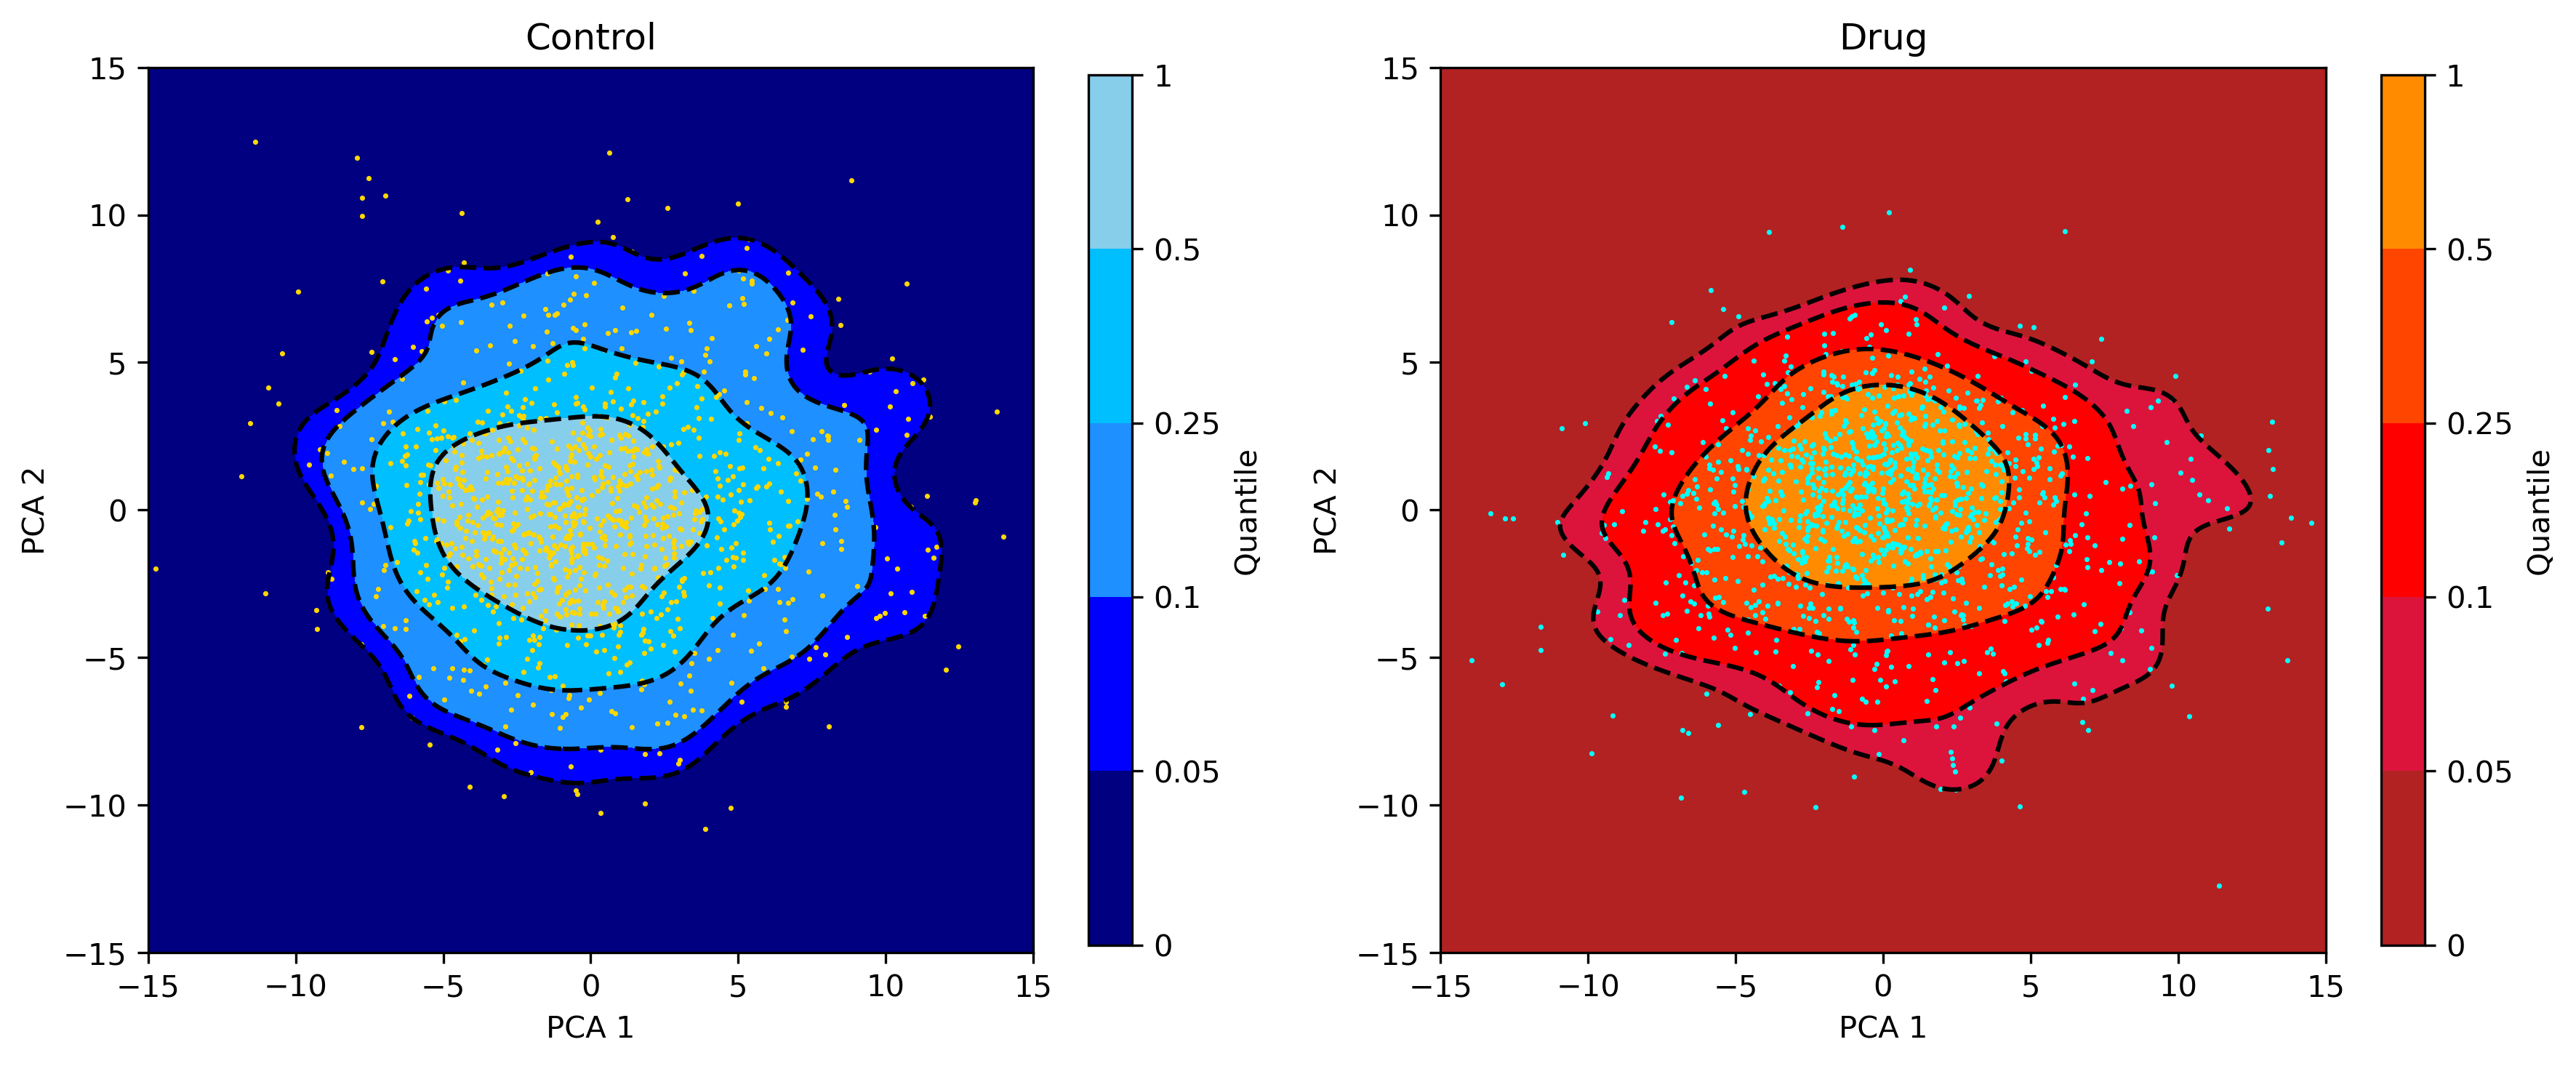

In [98]:
ds.performDimReduction()
ds.makeKDE(show_plot=True, save_to='../figures/cluster_analysis.png', resolution=1000)

In [99]:
df_unfiltered = ds.makeSelection(q_control=-1, q_drug=-1)
df_05 = ds.makeSelection(q_control=0.05, q_drug=0.05)
df_10 = ds.makeSelection(q_control=0.1, q_drug=0.1)
df_25 = ds.makeSelection(q_control=0.25, q_drug=0.25)

In [100]:
df_unfiltered.to_csv('feature_data/features_00.csv', index=False)
df_05.to_csv('feature_data/features_05.csv', index=False)
df_10.to_csv('feature_data/features_10.csv', index=False)
df_25.to_csv('feature_data/features_25.csv', index=False)